<a href="https://colab.research.google.com/github/SDS-AAU/SDS-master/blob/master/M3/notebooks/Simple_LSTM_stock_prediction_with_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 7.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas_datareader import data as pdr
import datetime as dt

import seaborn as sns
sns.set()

In [3]:
start = dt.datetime(2020,1,1)
end = dt.datetime.now()

In [4]:
data =  pdr.DataReader("^OMXC25",'yahoo', start=start, end=end)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 2020-01-02 to 2021-11-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       457 non-null    float64
 1   Low        457 non-null    float64
 2   Open       457 non-null    float64
 3   Close      457 non-null    float64
 4   Volume     457 non-null    float64
 5   Adj Close  457 non-null    float64
dtypes: float64(6)
memory usage: 25.0 KB


In [6]:
data_diff = data.diff()

In [7]:
#data_diff = data.pct_change()

In [8]:
data_diff

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-7.609985,-14.589966,-2.229980,-15.699951,3900.0,-15.699951
2020-01-06,-14.929932,-17.719971,-14.929932,-2.390015,386800.0,-2.390015
2020-01-07,16.679932,17.510010,3.049927,5.809937,977500.0,5.809937
2020-01-08,-12.089966,-5.229980,-0.229980,-1.939941,9220800.0,-1.939941
...,...,...,...,...,...,...
2021-11-15,-3.219971,5.019897,13.020020,-10.829956,-2295300.0,-10.829956
2021-11-16,-3.469971,-5.309937,-2.569946,-7.479980,-594000.0,-7.479980
2021-11-17,0.489990,-2.430054,-11.880005,0.069946,-1009600.0,0.069946


In [9]:
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [10]:
# normalizing
scaler = MinMaxScaler(feature_range=(-1, 1))
data_diff['Adj_Close_scaled'] = scaler.fit_transform(data_diff['Adj Close'].values.reshape(-1, 1))

In [11]:
# create targets by shifting
data_diff['Adj_Close_scaled+1'] = data_diff.Adj_Close_scaled.shift(-1, fill_value=data_diff.Adj_Close_scaled.iloc[-1])

In [12]:
# get the data as matrix
data_p = data_diff.iloc[1:,6:].values.astype('float32')

In [13]:
data_p

array([[ 0.03672679,  0.22259384],
       [ 0.22259384,  0.33710232],
       [ 0.33710232,  0.2288789 ],
       [ 0.2288789 ,  0.35497734],
       [ 0.35497734,  0.2653261 ],
       [ 0.2653261 ,  0.30777714],
       [ 0.30777714,  0.31894946],
       [ 0.31894946,  0.5212954 ],
       [ 0.5212954 ,  0.2407484 ],
       [ 0.2407484 ,  0.41488573],
       [ 0.41488573,  0.2841762 ],
       [ 0.2841762 ,  0.36600986],
       [ 0.36600986,  0.1825157 ],
       [ 0.1825157 ,  0.402319  ],
       [ 0.402319  , -0.17190422],
       [-0.17190422,  0.36978057],
       [ 0.36978057,  0.5130551 ],
       [ 0.5130551 , -0.02834841],
       [-0.02834841,  0.29535022],
       [ 0.29535022,  0.26937467],
       [ 0.26937467,  0.5405665 ],
       [ 0.5405665 ,  0.69585204],
       [ 0.69585204,  0.4263359 ],
       [ 0.4263359 ,  0.21980162],
       [ 0.21980162,  0.16128933],
       [ 0.16128933,  0.5130568 ],
       [ 0.5130568 ,  0.19885482],
       [ 0.19885482,  0.21896292],
       [ 0.21896292,

In [14]:
# split into train and test sets
train_size = int(len(data_p) * 0.67)
test_size = len(data_p) - train_size

train, test = data_p[0:train_size,:], data_p[train_size:len(data_p),:]
print(len(train), len(test))

305 151


In [15]:
X_train = train[:,0]
y_train = train[:,1]

X_test = test[:,0]
y_test = test[:,1]

In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

In [17]:
X_train.shape

(305, 1, 1)

In [18]:
X_train

array([[[ 0.03672679]],

       [[ 0.22259384]],

       [[ 0.33710232]],

       [[ 0.2288789 ]],

       [[ 0.35497734]],

       [[ 0.2653261 ]],

       [[ 0.30777714]],

       [[ 0.31894946]],

       [[ 0.5212954 ]],

       [[ 0.2407484 ]],

       [[ 0.41488573]],

       [[ 0.2841762 ]],

       [[ 0.36600986]],

       [[ 0.1825157 ]],

       [[ 0.402319  ]],

       [[-0.17190422]],

       [[ 0.36978057]],

       [[ 0.5130551 ]],

       [[-0.02834841]],

       [[ 0.29535022]],

       [[ 0.26937467]],

       [[ 0.5405665 ]],

       [[ 0.69585204]],

       [[ 0.4263359 ]],

       [[ 0.21980162]],

       [[ 0.16128933]],

       [[ 0.5130568 ]],

       [[ 0.19885482]],

       [[ 0.21896292]],

       [[ 0.39924553]],

       [[ 0.36992034]],

       [[ 0.4390441 ]],

       [[ 0.20848952]],

       [[ 0.09202579]],

       [[-0.47493562]],

       [[-0.0650752 ]],

       [[ 0.24354234]],

       [[-0.24577715]],

       [[-0.17246334]],

       [[ 0.4227067 ]],



In [19]:
# build the network

model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train, y_train, epochs=20, batch_size=20, verbose=2)

Epoch 1/20
16/16 - 2s - loss: 0.1498 - 2s/epoch - 136ms/step
Epoch 2/20
16/16 - 0s - loss: 0.1385 - 31ms/epoch - 2ms/step
Epoch 3/20
16/16 - 0s - loss: 0.1284 - 29ms/epoch - 2ms/step
Epoch 4/20
16/16 - 0s - loss: 0.1189 - 30ms/epoch - 2ms/step
Epoch 5/20
16/16 - 0s - loss: 0.1107 - 30ms/epoch - 2ms/step
Epoch 6/20
16/16 - 0s - loss: 0.1035 - 28ms/epoch - 2ms/step
Epoch 7/20
16/16 - 0s - loss: 0.0968 - 32ms/epoch - 2ms/step
Epoch 8/20
16/16 - 0s - loss: 0.0911 - 33ms/epoch - 2ms/step
Epoch 9/20
16/16 - 0s - loss: 0.0864 - 34ms/epoch - 2ms/step
Epoch 10/20
16/16 - 0s - loss: 0.0822 - 33ms/epoch - 2ms/step
Epoch 11/20
16/16 - 0s - loss: 0.0789 - 37ms/epoch - 2ms/step
Epoch 12/20
16/16 - 0s - loss: 0.0764 - 33ms/epoch - 2ms/step
Epoch 13/20
16/16 - 0s - loss: 0.0746 - 34ms/epoch - 2ms/step
Epoch 14/20
16/16 - 0s - loss: 0.0728 - 38ms/epoch - 2ms/step
Epoch 15/20
16/16 - 0s - loss: 0.0719 - 35ms/epoch - 2ms/step
Epoch 16/20
16/16 - 0s - loss: 0.0712 - 34ms/epoch - 2ms/step
Epoch 17/20
16/16

In [22]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [23]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 18.9939 RMSE
Test Score: 18.5099 RMSE


In [25]:
data_diff['Adj_close_pred'] = data_diff['Adj Close']

In [26]:
data_diff['Adj_close_pred'].iloc[-testPredict.shape[0]:] = testPredict.flatten()

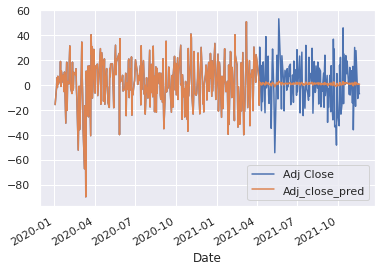

In [27]:
data_diff.loc[:,['Adj Close','Adj_close_pred']].plot()

In [28]:
pred_sign = pd.DataFrame(zip(testPredict.flatten(), y_test.flatten())) > 0

In [29]:
pred_sign

,0,1
0,True,True
1,True,False
2,True,True
3,True,False
4,True,True
...,...,...
146,True,False
147,True,True
148,True,False
149,True,False


In [30]:
(pred_sign[0] == pred_sign[1]).sum()/len(pred_sign)

0.5496688741721855

Introducing multi-step

In [31]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [32]:
# reshape into X=t and Y=t+1
look_back = 5
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [33]:
# build the network

model = Sequential()
model.add(LSTM(16, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 16)             1152      
                                                                 
 lstm_2 (LSTM)               (None, 4)                 336       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
299/299 - 4s - loss: 0.0774 - 4s/epoch - 13ms/step
Epoch 2/10
299/299 - 1s - loss: 0.0724 - 1s/epoch - 4ms/step
Epoch 3/10
299/299 - 1s - loss: 0.0720 - 1s/epoch - 4ms/step
Epoch 4/10
299/299 - 1s - loss: 0.0726 - 1s/epoch - 3ms/step
Epoch 5/10
299/299 - 1s - loss: 0.0717 - 1s/epoch - 4ms/step
Epoch 6/10
299/299 - 1s - loss: 0.0714 - 1s/epoch - 4ms/step
Epoch 7/10
299/299 - 1s - loss: 0.0725 - 1s/epoch - 4ms/step
Epoch 8/10
299/299 - 1s - loss: 0.0721 - 1s/epoch - 4ms/step
Epoch 9/10
299/299 - 1s - loss: 0.0713 - 1s/epoch - 4ms/step
Epoch 10/10
299/299 - 1s - loss: 0.0718 - 1s/epoch - 3ms/step


In [36]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [37]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [38]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 19.03 RMSE
Test Score: 18.62 RMSE


In [39]:
data_diff['Adj_close_pred'] = data_diff['Adj Close']

In [40]:
data_diff['Adj_close_pred'].iloc[-testPredict.shape[0]:] = testPredict.flatten()

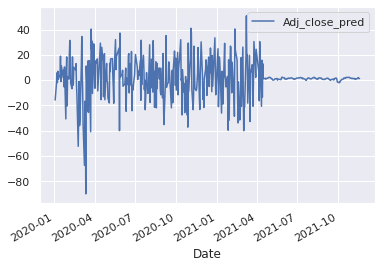

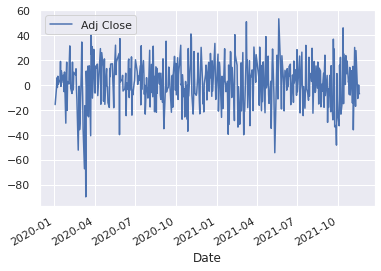

In [41]:
data_diff.loc[:,['Adj_close_pred']].plot()
data_diff.loc[:,['Adj Close']].plot()

In [42]:
pred_sign = pd.DataFrame(zip(testPredict.flatten(), y_test.flatten())) > 0
(pred_sign[0] == pred_sign[1]).sum()/len(pred_sign)

0.5517241379310345

In [43]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [176]:
start = dt.datetime(2021,5,1)
end = dt.datetime.now()

In [177]:
ETH =  pdr.DataReader('ETH-USD','yahoo', start=start, end=end)
BTC =  pdr.DataReader('BTC-USD','yahoo', start=start, end=end)
ADA =  pdr.DataReader('ADA-USD','yahoo', start=start, end=end)
DOGE =  pdr.DataReader('DOGE-USD','yahoo', start=start, end=end)
BNB =  pdr.DataReader('BNB-USD','yahoo', start=start, end=end)

In [178]:
data = pd.DataFrame({'ETH':ETH['Adj Close'], 
                     'BTC':BTC['Adj Close'], 
                     'ADA':ADA['Adj Close'], 
                     'DOGE': DOGE['Adj Close'], 
                     'BNB':BNB['Adj Close']})

In [179]:
data

,ETH,BTC,ADA,DOGE,BNB
Date,,,,,
2021-05-01,2945.892822,57828.050781,1.353071,0.392987,619.347229
2021-05-02,2952.056152,56631.078125,1.326812,0.376046,622.101013
2021-05-03,3431.086182,57200.292969,1.362030,0.441707,675.684082
2021-05-04,3253.629395,53333.539062,1.274111,0.541334,611.200317
2021-05-05,3522.783203,57424.007812,1.475529,0.657633,651.662720
...,...,...,...,...,...
2021-11-18,4000.650879,56942.136719,1.788331,0.221383,532.237610
2021-11-19,4298.306641,58119.578125,1.864793,0.233110,581.530823
2021-11-20,4409.931152,59697.195312,1.921736,0.233024,603.840027


In [180]:
data = data.sort_index(ascending=True)

In [181]:
data['ADA_shift'] = data['ADA'].shift(-1, fill_value=data['ADA'].iloc[-1])

In [182]:
test_size = int(len(data) * 0.2) # the test data will be 20% (0.2) of the entire data
train = data.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = data.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

(165, 6) (41, 6)


In [183]:
train

,ETH,BTC,ADA,DOGE,BNB,ADA_shift
Date,,,,,,
2021-05-01,2945.892822,57828.050781,1.353071,0.392987,619.347229,1.326812
2021-05-02,2952.056152,56631.078125,1.326812,0.376046,622.101013,1.362030
2021-05-03,3431.086182,57200.292969,1.362030,0.441707,675.684082,1.274111
2021-05-04,3253.629395,53333.539062,1.274111,0.541334,611.200317,1.475529
2021-05-05,3522.783203,57424.007812,1.475529,0.657633,651.662720,1.650124
...,...,...,...,...,...,...
2021-10-08,3563.759277,53967.847656,2.237176,0.243851,419.102051,2.266615
2021-10-09,3575.716797,54968.222656,2.266615,0.246596,421.549469,2.197214
2021-10-10,3425.852783,54771.578125,2.197214,0.229805,405.069305,2.173389


In [184]:
X_train = train.iloc[:,:5].values
y_train = train.iloc[:,5].values

X_test = test.iloc[:,:5].values
y_test = test.iloc[:,5].values

In [185]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

In [186]:
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))

X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1,1))

In [187]:
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)


In [188]:
print(generator[0][0].shape)

(32, 5, 5)


In [189]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150)               93600     
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 93,751
Trainable params: 93,751
Non-trainable params: 0
_________________________________________________________________


In [190]:
model.fit(generator,epochs=5)

Epoch 1/5
5/5 [==============================] - 1s 9ms/step - loss: 0.2739
Epoch 2/5
5/5 [==============================] - 0s 10ms/step - loss: 0.1970
Epoch 3/5
5/5 [==============================] - 0s 11ms/step - loss: 0.1346
Epoch 4/5
5/5 [==============================] - 0s 12ms/step - loss: 0.0893
Epoch 5/5
5/5 [==============================] - 0s 10ms/step - loss: 0.0693


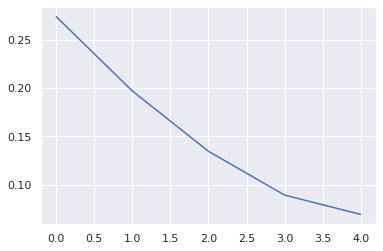

In [191]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [192]:
test_generator = TimeseriesGenerator(X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(32, 5, 5)


In [193]:
y_pred_scaled = model.predict(test_generator)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({'y_true':y_test.flatten()[n_input:],'y_pred':y_pred.flatten()})
print(results)

      y_true    y_pred
0   2.112962  2.393869
1   2.185950  2.397920
2   2.136591  2.406193
3   2.154199  2.415415
4   2.166815  2.420263
5   2.123435  2.419646
6   2.144066  2.427432
7   2.138777  2.420707
8   1.913237  2.415475
9   1.988219  2.410885
10  2.012187  2.391185
11  1.957422  2.374671
12  1.965026  2.366272
13  1.950002  2.348857
14  1.971377  2.336635
15  2.063701  2.332073
16  1.984882  2.336618
17  1.986206  2.343087
18  2.006609  2.343199
19  2.021872  2.335471
20  2.124419  2.327775
21  2.273483  2.316154
22  2.101802  2.320395
23  2.085524  2.343533
24  2.045766  2.360381
25  2.053104  2.375382
26  2.040853  2.380070
27  2.015587  2.368196
28  1.877235  2.349685
29  1.875540  2.336907
30  1.788331  2.314264
31  1.864793  2.301323
32  1.921736  2.279045
33  1.839763  2.263573
34  1.780623  2.257353
35  1.780623  2.254141


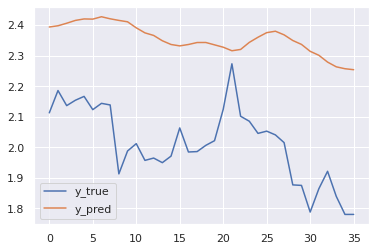

In [194]:
results.plot()

In [195]:
pred_sign = results.diff(1) > 0

In [196]:
pred_sign.y_true == pred_sign.y_pred

0      True
1      True
2     False
3      True
4      True
5      True
6      True
7      True
8      True
9     False
10    False
11     True
12    False
13     True
14    False
15    False
16    False
17     True
18     True
19    False
20    False
21    False
22    False
23    False
24    False
25     True
26    False
27     True
28     True
29     True
30     True
31    False
32    False
33     True
34     True
35     True
dtype: bool

In [197]:
(pred_sign.y_true == pred_sign.y_pred).sum()/len(pred_sign)

0.5555555555555556

From here some experimental backtesting...

In [199]:
data['prediction'] = 0

In [200]:
data['prediction'][-len(results.diff(1).y_pred):] = results.diff(1).y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [201]:
data['signal'] = 0

In [202]:
data['signal'][-len(results.diff(1).y_pred):] = [-1 if i <= 0 else 1 for i in results.diff(1).y_pred]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [203]:
data['ADA_diff'] = data['ADA'].diff(1)

In [204]:
data

,ETH,BTC,ADA,DOGE,BNB,ADA_shift,prediction,signal,ADA_diff
Date,,,,,,,,,
2021-05-01,2945.892822,57828.050781,1.353071,0.392987,619.347229,1.326812,0.000000,0,NaN
2021-05-02,2952.056152,56631.078125,1.326812,0.376046,622.101013,1.362030,0.000000,0,-0.026259
2021-05-03,3431.086182,57200.292969,1.362030,0.441707,675.684082,1.274111,0.000000,0,0.035218
2021-05-04,3253.629395,53333.539062,1.274111,0.541334,611.200317,1.475529,0.000000,0,-0.087919
2021-05-05,3522.783203,57424.007812,1.475529,0.657633,651.662720,1.650124,0.000000,0,0.201418
...,...,...,...,...,...,...,...,...,...
2021-11-18,4000.650879,56942.136719,1.788331,0.221383,532.237610,1.864793,-0.012941,-1,-0.087209
2021-11-19,4298.306641,58119.578125,1.864793,0.233110,581.530823,1.921736,-0.022278,-1,0.076462
2021-11-20,4409.931152,59697.195312,1.921736,0.233024,603.840027,1.839763,-0.015471,-1,0.056943


In [205]:
data['signal_adj'] = data.apply(lambda t: 0 if abs(t['prediction']) < 0.03 else t['signal'], axis=1)

In [206]:
data

,ETH,BTC,ADA,DOGE,BNB,ADA_shift,prediction,signal,ADA_diff,signal_adj
Date,,,,,,,,,,
2021-05-01,2945.892822,57828.050781,1.353071,0.392987,619.347229,1.326812,0.000000,0,NaN,0.0
2021-05-02,2952.056152,56631.078125,1.326812,0.376046,622.101013,1.362030,0.000000,0,-0.026259,0.0
2021-05-03,3431.086182,57200.292969,1.362030,0.441707,675.684082,1.274111,0.000000,0,0.035218,0.0
2021-05-04,3253.629395,53333.539062,1.274111,0.541334,611.200317,1.475529,0.000000,0,-0.087919,0.0
2021-05-05,3522.783203,57424.007812,1.475529,0.657633,651.662720,1.650124,0.000000,0,0.201418,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-11-18,4000.650879,56942.136719,1.788331,0.221383,532.237610,1.864793,-0.012941,-1,-0.087209,0.0
2021-11-19,4298.306641,58119.578125,1.864793,0.233110,581.530823,1.921736,-0.022278,-1,0.076462,0.0
2021-11-20,4409.931152,59697.195312,1.921736,0.233024,603.840027,1.839763,-0.015471,-1,0.056943,0.0


In [207]:
# Set the initial capital
initial_capital= float(10000.0)

In [208]:
# Create a DataFrame `positions`
positions = pd.DataFrame(index=data.index).fillna(0.0)

In [209]:
# Buy a 100 shares
positions['ADA'] = 100*data['signal_adj']   

In [210]:
# Initialize the portfolio with value owned   
portfolio = positions.multiply(data['ADA'], axis=0)

In [211]:
# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(data['ADA'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['ADA'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

            ADA  holdings     cash    total  returns
Date                                                
2021-05-01  0.0       0.0  10000.0  10000.0      NaN
2021-05-02  0.0       0.0  10000.0  10000.0      0.0
2021-05-03  0.0       0.0  10000.0  10000.0      0.0
2021-05-04  0.0       0.0  10000.0  10000.0      0.0
2021-05-05  0.0       0.0  10000.0  10000.0      0.0


In [212]:
# Print the last lines of `portfolio`
portfolio.tail() 

,ADA,holdings,cash,total,returns
Date,,,,,
2021-11-18,0.0,0.0,9998.469901,9998.469901,0.0
2021-11-19,0.0,0.0,9998.469901,9998.469901,0.0
2021-11-20,0.0,0.0,9998.469901,9998.469901,0.0
2021-11-21,0.0,0.0,9998.469901,9998.469901,0.0
2021-11-22,0.0,0.0,9998.469901,9998.469901,0.0
